In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, execute
from qiskit.visualization import plot_histogram
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
import matplotlib.pyplot as plt
from utils.matrix_operations import matmul, tensor_prod
np.set_printoptions(threshold=sys.maxsize)

In [2]:
SIMULATION = True

In [3]:
# Get on one of the IBM Q machines
from qiskit import IBMQ

if not SIMULATION:
    IBMQ.load_account() # Load account from disk
    IBMQ.providers()    # List all available providers
    provider = IBMQ.get_provider(hub='ibm-q-ornl', project='brookhaven')
    provider.backends()
    backend = provider.get_backend('ibmq_rochester')
    backend

[-6.00000000e+00+0.00000000e+00j -4.10644987e+00+0.00000000e+00j
 -4.00000000e+00+0.00000000e+00j -4.00000000e+00+0.00000000e+00j
 -3.02503016e+00+0.00000000e+00j -3.02503016e+00+0.00000000e+00j
 -3.02503016e+00+0.00000000e+00j -3.02503016e+00+0.00000000e+00j
 -3.02503016e+00+0.00000000e+00j -3.02503016e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -1.20710678e+00+0.00000000e+00j
 -1.20710678e+00+0.00000000e+00j -1.20710678e+00+0.00000000e+00j
 -1.20710678e+00+0.00000000e+00j -1.20710678e+00+0.00000000e+00j
 -1.20710678e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
 -1.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
 -1.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
 -1.00000000e+00+0.00000000e+00j -7.65072664e-02+0.00000000e+00j
 -2.57969148e-16+9.83397184e-17j -2.57969148e-16-9.83397184e-17j
 -1.13375413e-16+6.74871644e-17j -1.13375413e-16-6.74871644e-17j
  1.62159872e-17-3.117877

c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


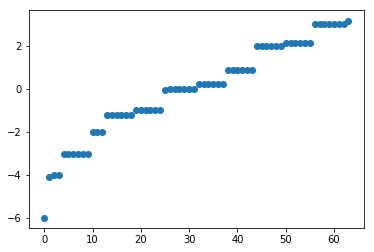

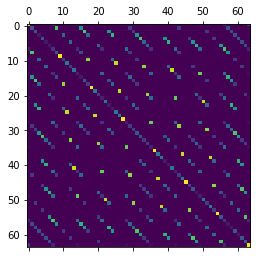

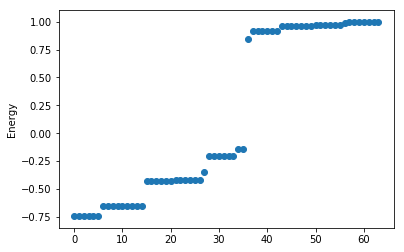

In [4]:
# 2 triangle plaquettes
T = 2
H = TrianglePlaquetteHamiltonian(1, 1, 2)
matH = H.matrix_form()

spectrum, _ = H.eigensystem()
print(np.sort(spectrum))
plt.scatter(range(spectrum.shape[0]), np.sort(spectrum))
plt.show()
exact = expm(-1j*matH*T)
spectrum, _ = eig(exact)
plt.matshow(np.abs(exact))
plt.show()

plt.scatter(range(spectrum.shape[0]), np.sort(spectrum))
plt.ylabel("Energy")
plt.show()

33


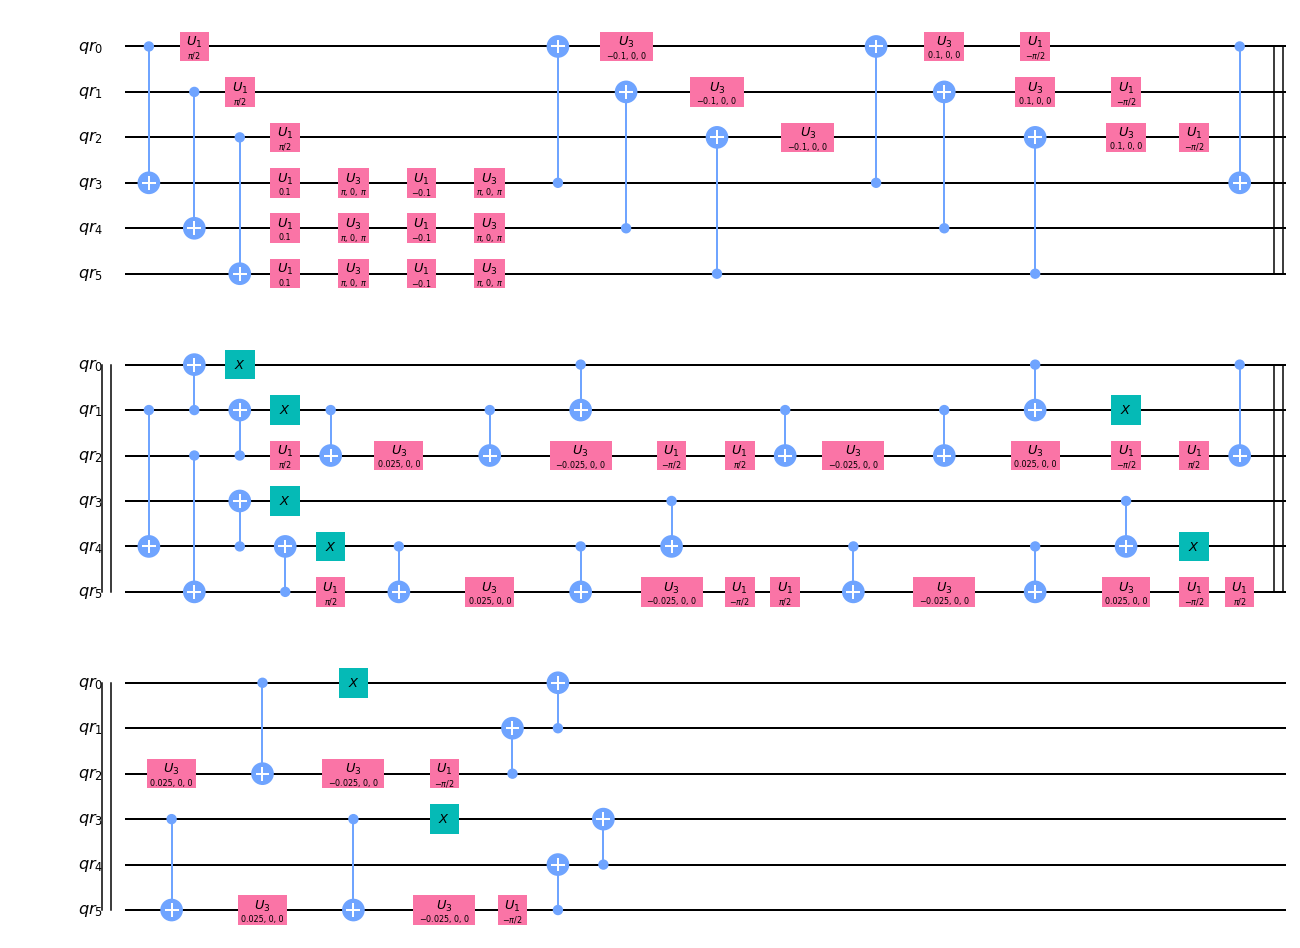

In [5]:
qr = QuantumRegister(6, 'qr')
circ = QuantumCircuit(qr)
circ = H.trotter_circuit_optimized(circ, qr, 0.1, 1)
print(circ.depth())
circ.draw(output='mpl')

c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


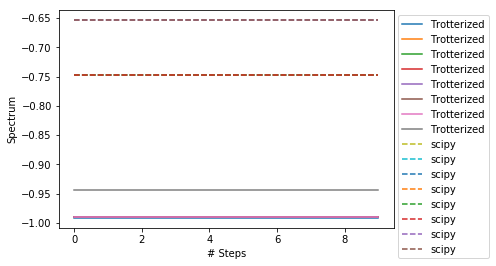

In [6]:
# Initialize a simulator if SIMULATION is True.
if SIMULATION:
    backend = BasicAer.get_backend('unitary_simulator')

# Construct quantum circuits with different number of steps
tr_spectra = []
for n_steps in range(10):
    # Construct Circuit
    qr = QuantumRegister(6, 'qr')
    circ = QuantumCircuit(qr)
    circ = H.trotter_circuit_optimized(circ, qr, 1, 1)
    job = execute(circ, backend)
    eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
    tr_spectra.append(sorted(eigvals)[:8])
plt.plot(range(10), tr_spectra, label='Trotterized')
plt.plot(range(10), np.tile(np.reshape(sorted(spectrum)[:8], [1, -1]), [10, 1]), linestyle='--', label='scipy')
plt.xlabel("# Steps")
plt.ylabel("Spectrum")
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()

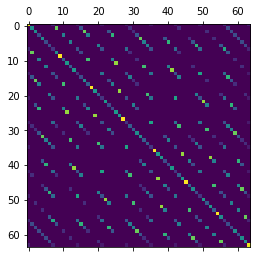

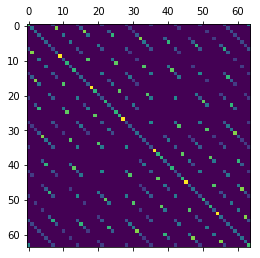

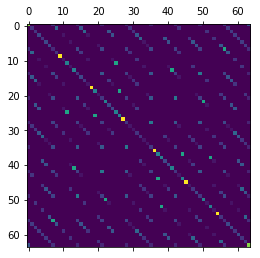

[1.63490702 0.27289075 0.21773974 0.21773974 0.21773974 0.21773974
 0.21773974 0.21773974 0.27289075 0.51388702 0.30720432 0.66524575
 0.53815339 0.29272496 0.29272496 0.33855672 0.30720432 0.66524575
 0.53815339 0.29272496 0.29272496 0.33855672 0.44394893 0.11362087
 0.11362087 0.51355662 0.54818499 0.35598437 0.30720432 0.66524575
 0.53815339 0.29272496 0.29272496 0.33855672 0.44394893 0.11362087
 0.11362087 0.51355662 0.54818499 0.35598437 0.44394893 0.11362087
 0.11362087 0.51355662 0.54818499 0.35598437 0.26028376 0.24711678
 0.42826667 0.42826667 0.38039047 0.42826667 0.38039047 0.38039047
 1.18657494 0.26028376 0.66524575 0.30720432 0.33855672 0.29272496
 0.29272496 0.53815339 1.99498997 0.09864538 0.12114602 0.12068904
 0.09864538 0.30710831 0.30710831 0.87743558 1.17066247 0.09864538
 0.12114602 0.12068904 0.09864538 0.30710831 0.30710831 0.87743558
 1.17066247 0.19725133 0.44895025 0.3265991  0.55098672 0.37877658
 0.55098672 0.37877658 0.80082279 0.40396764 0.19725133 0.5481

In [9]:
T = 1
backend = BasicAer.get_backend('unitary_simulator')
exact = expm(-1j*matH*T)
plt.matshow(np.abs(exact))
plt.show()
qr = QuantumRegister(6, 'qr')
circ = QuantumCircuit(qr)
circ = H.trotter_circuit_optimized(circ, qr, T, 20)
job = execute(circ, backend)
trotterized_mat = job.result().get_unitary(circ, decimals=3)
dif = trotterized_mat - exact
plt.matshow(np.abs(trotterized_mat))
plt.show()
plt.matshow(np.abs(dif))
plt.show()
print(np.abs(dif[np.nonzero(dif)]))
print(trotterized_mat)

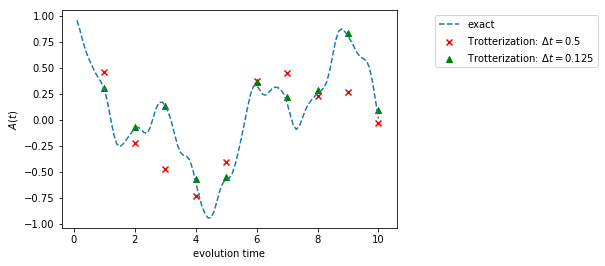

In [10]:
# Initialize a simulator if SIMULATION is True.
if SIMULATION:
    backend = BasicAer.get_backend('unitary_simulator')
    
H = TrianglePlaquetteHamiltonian(0.5, 1, 2)

# Compare exact <0|U|0> with trotterized <0|(Uel Ucoup Upla)^n|0> with 2 steps and 8 steps per T=1
exact_exps = []
tr_exps2 = []
tr_exps8 = []
zerostate = np.zeros([2**6, 1])
zerostate[0, 0] = 1
for t in np.arange(0.1, 10.1, 0.1):
    exact_exps.append(np.real(np.matmul(np.matmul(zerostate.T, expm(-1j*H.matrix_form()*t)), zerostate)[0, 0]))
    
for t in np.arange(1, 11):
    # Construct Circuit with n_steps = 20
    qr = QuantumRegister(6, 'qr')
    circ1 = QuantumCircuit(qr)
    circ1 = H.trotter_circuit_optimized(circ1, qr, t, 2*t, True)
    job = execute(circ1, backend)
    tr_unitary1 = job.result().get_unitary(circ1, decimals=3)
    tr_exps2.append(np.dot(np.dot(zerostate.T, tr_unitary1), zerostate)[0, 0])
    # Construct Circuit with n_steps = 80
    qr = QuantumRegister(6, 'qr')
    circ2 = QuantumCircuit(qr)
    circ2 = H.trotter_circuit_optimized(circ2, qr, t, 8*t, True)
    job = execute(circ2, backend)
    tr_unitary2 = job.result().get_unitary(circ2, decimals=3)
    tr_exps8.append(np.dot(np.dot(zerostate.T, tr_unitary2), zerostate)[0, 0])
plt.plot(np.arange(0.1, 10.1, 0.1), exact_exps, label='exact', linestyle='--')
plt.scatter(range(1, 11), tr_exps2, label='Trotterization: $\Delta t=0.5$', c = 'r', marker='x')
plt.scatter(range(1, 11), tr_exps8, label='Trotterization: $\Delta t=0.125$', c='g', marker='^')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlabel('evolution time')
plt.ylabel('$A(t)$')
plt.show()

In [ ]:
# Initialize a simulator if SIMULATION is True.
#if SIMULATION:
backend = BasicAer.get_backend('unitary_simulator')
    
# Compare exact <0|U|0> with trotterized <0|(Uel Ucoup Upla)^n|0> with 5 steps and 20 steps
exact_exps = []

for t in np.arange(1, 11):
    zerostate = np.zeros([2**6, 1])
    zerostate[-1, 0] = 1
    exact = expm(-1j*H.matrix_form()*t)
    exact_exps.append(np.dot(np.dot(zerostate.T, expm(-1j*H.matrix_form()*t)), zerostate)[0, 0])
exact_exps = np.array(exact_exps)
    
error_list = [] # list of errors for delta t = 1/1, 1/2, ..., 1/10
depth_list = []
error_list_nop = []
depth_list_nop = []
for n_steps in range(1, 11):
    """
    tr_exps = [] # list of expectation values
    for t in np.arange(1, 11):
        # Construct Circuit
        qr = QuantumRegister(6, 'qr')
        circ = QuantumCircuit(qr)
        circ = H.trotter_circuit_optimized(circ, qr, t, n_steps*t)
        job = execute(circ, backend)
        tr_unitary = job.result().get_unitary(circ, decimals=3)
        tr_exps.append(np.dot(np.dot(zerostate.T, tr_unitary), zerostate)[0, 0])
    """
    # Optimized circuit
    qr = QuantumRegister(6, 'qr')
    circ = QuantumCircuit(qr)
    circ = H.trotter_circuit_optimized(circ, qr, 10, n_steps*10)
    job = execute(circ, backend)
    tr_unitary = job.result().get_unitary(circ, decimals=3)
    tr_exp = np.dot(np.dot(zerostate.T, tr_unitary), zerostate)[0, 0]
    error_list.append(np.abs(tr_exp - exact_exps[-1]))
    depth_list.append(circ.depth())
    
    # Non-optimized 
    qr = QuantumRegister(6, 'qr')
    circ = QuantumCircuit(qr)
    circ = H.trotter_circuit(circ, qr, 10, n_steps*10)
    job = execute(circ, backend)
    tr_unitary = job.result().get_unitary(circ, decimals=3)
    tr_exp = np.dot(np.dot(zerostate.T, tr_unitary), zerostate)[0, 0]
    error_list_nop.append(np.abs(tr_exp - exact_exps[-1]))
    depth_list_nop.append(circ.depth())
    
plt.plot(range(1, 11), error_list, label='MAE errors (Optimized)')
#plt.plot(range(1, 11), error_list_nop, label='MAE errors (Non-optimized)')
plt.legend()
plt.xlabel('number of steps per $t=1$')
plt.ylabel('Error of <0|U|0>')
plt.show()
plt.plot(range(1, 11), depth_list, label='Circuit Depth (Optimized)')
#plt.plot(range(1, 11), depth_list_nop, label='Circuit Depth (Non-optimized)')
plt.legend()
plt.xlabel('number of steps per $t=1$')
plt.ylabel('Quantum Circuit Depth')
plt.show()

In [ ]:
H = TrianglePlaquetteHamiltonian(1, 1, 2)
permH = H.gauge_rotation_basis()
plt.matshow(np.abs(permH))
plt.show()

In [ ]:
# Initialize a simulator if SIMULATION is True.
if SIMULATION:
    backend = BasicAer.get_backend('qasm_simulator')
    
H = TrianglePlaquetteHamiltonian(0.5, 1, 2)
T = 10

# Compare exact <0|U^+ X_1 U|0> with trotterized circuit with 2 steps and 8 steps per T=1
exact_exps = []
tr_exps2 = []
tr_exps8 = []
zerostate = np.zeros([2**6, 1])
zerostate[0, 0] = 1
Sx = np.array([[0, 1], [1, 0]])
Sx_full = tensor_prod([Sx]*6)
#exact_exp = np.real(matmul([zerostate.T, expm(1j*H.matrix_form()*T), Sx_full, expm(-1j*H.matrix_form()*T) , zerostate])[0, 0])
exact_prob = np.abs(matmul([expm(-1j*H.matrix_form()*T) , zerostate]))**2
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s 
exact_dist = {dec_to_binary_str(idx, 6): exact_prob[idx][0] for idx in np.nonzero(exact_prob)[0]}
"""
plt.bar(np.arange(len(exact_dist)), height=list(exact_dist.values()))
plt.xticks(np.arange(len(exact_dist)), exact_dist.keys(), rotation=30)
plt.show()"""

# Construct Circuit with n_steps = 20
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')
circ1 = QuantumCircuit(qr, cr)
circ1 = H.trotter_circuit_optimized(circ1, qr, T, 2*T)
circ1.measure(qr, cr)
job = execute(circ1, backend, shots=1024)
result_sim = job.result()
tr_dist2 = result_sim.get_counts(circ1)
#probs = [c/result_sim.results[0].shots for i, c in result_sim.get_counts(circ1).items()]
#tr_exps2.append(0*probs[0]+1*probs[1])

    
# Construct Circuit with n_steps = 80
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')
circ2 = QuantumCircuit(qr, cr)
circ2 = H.trotter_circuit_optimized(circ2, qr, T, 8*T)
circ2.measure(qr, cr)
job = execute(circ2, backend, shots=1024)
result_sim = job.result()
tr_dist8 = result_sim.get_counts(circ2)
#probs = [c/result_sim.results[0].shots for i, c in result_sim.get_counts(circ2).items()]
#tr_exps8.append(0*probs[0]+1*probs[1])

"""
plt.plot(np.arange(0.1, 10.1, 0.1), exact_exps, label='exact', linestyle='--')
plt.scatter(range(1, 11), tr_exps2, label='Trotterization: $\Delta t=0.5$', c = 'r', marker='x')
plt.scatter(range(1, 11), tr_exps8, label='Trotterization: $\Delta t=0.125$', c='g', marker='^')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.xlabel('evolution time')
plt.ylabel('$A(t)$')
plt.show()
"""


In [ ]:
plot_histogram(exact_dist)

In [ ]:
plot_histogram(tr_dist2)

In [ ]:
plot_histogram(tr_dist8)

In [20]:
H = TrianglePlaquetteHamiltonian(0.5, 1, 2)

exact_exps = []
zerostate = np.zeros([2**6, 1])
zerostate[0, 0] = 1
exact_prob = np.abs(matmul([expm(-1j*H.matrix_form()*0.1) , zerostate]))**2
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s 
exact_dist = {dec_to_binary_str(idx, 6): exact_prob[idx][0] for idx in np.nonzero(exact_prob)[0]}
print(exact_dist)

backend = BasicAer.get_backend('qasm_simulator')
# Construct Circuit with n_steps = 80
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')
circ2 = QuantumCircuit(qr, cr)
circ2 = H.trotter_circuit_optimized(circ2, qr, 0.1,1)
circ2.measure(qr, cr)
job = execute(circ2, backend, shots=1024)
result_sim = job.result()
tr_dist = result_sim.get_counts(circ2)

{'000000': 0.925730983213898, '000111': 0.032233627249688035, '001110': 0.001394101406008281, '010101': 0.0013941014060082815, '011100': 0.0013941014060082815, '100011': 0.001394101406008281, '101010': 0.0013941014060082815, '110001': 0.001394101406008281, '111000': 0.03223362724968802, '111111': 0.0014371538506762328}


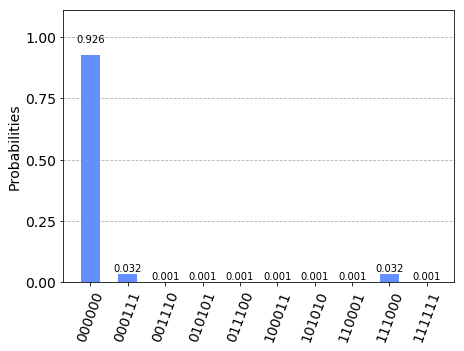

In [21]:
plot_histogram(exact_dist)

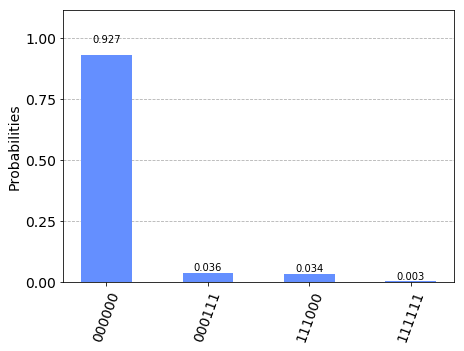

In [22]:
plot_histogram(tr_dist)